In [1]:
import cv2
import matplotlib.pyplot as plt

# EDA

In [2]:
# Load the images
empty = cv2.imread('../data/empty.png')
not_empty = cv2.imread('../data/not_empty.png')
empty = cv2.resize(empty, (15,15))
not_empty = cv2.resize(not_empty, (15,15))
empty = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)
not_empty = cv2.cvtColor(not_empty, cv2.COLOR_BGR2GRAY)

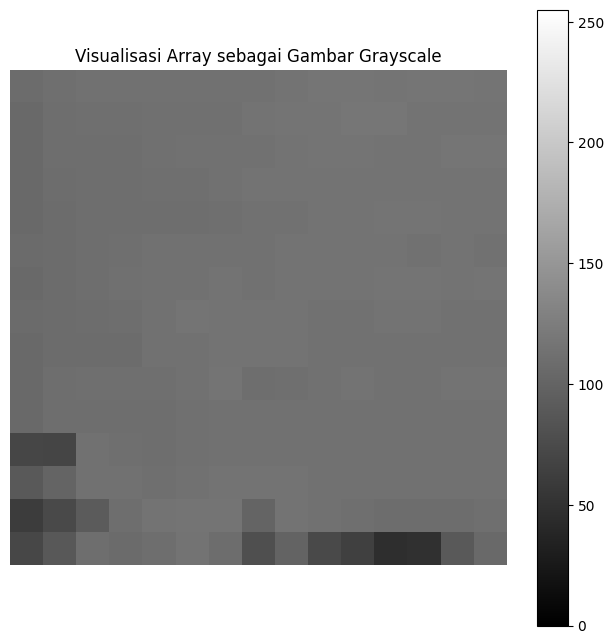

In [3]:
# Plot the array as an image
plt.figure(figsize=(8, 8))
plt.imshow(empty, cmap='gray', vmin=0, vmax=255)
plt.title('Visualisasi Array sebagai Gambar Grayscale')
plt.colorbar()
plt.axis('off')
plt.show()

# Start

In [4]:
import os
import cv2
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (15, 15))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            images.append(img_gray.flatten())
            labels.append(label)
    return images, labels

# Load empty images
empty_data, empty_labels = load_images_from_directory('empty', 0)  # Replace with your empty images folder

# Load not_empty images
not_empty_data, not_empty_labels = load_images_from_directory('not_empty', 1)  # Replace with your not_empty images folder



In [9]:
# Combine the data and labels
data = np.array(empty_data + not_empty_data)
labels = np.array(empty_labels + not_empty_labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [16]:
len(X_train)

2968

In [17]:

# Train and evaluate XGBoost model
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 1.0
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       1.00      1.00      1.00       435

    accuracy                           1.00       743
   macro avg       1.00      1.00      1.00       743
weighted avg       1.00      1.00      1.00       743



In [21]:
import pickle

with open('xgb_model_new.pkl', 'wb') as f:
    pickle.dump(xgb, f)

print("Models saved successfully.")

Models saved successfully.


In [19]:
def predict_empty(directory, label):
    # logistic_model = pickle.load(open("model/model.p", "rb"))
    total_images = 0
    correct_predictions = 0
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            total_images += 1
            img_resized = cv2.resize(img, (15, 15))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            flat_data = img_gray.flatten().reshape(1, -1)
            y_output = xgb.predict(flat_data)
            
            if y_output == label:
                correct_predictions += 1

    accuracy = correct_predictions / total_images if total_images > 0 else 0
    return accuracy

# Calculate accuracy for the 'empty_augmented' directory
accuracy_empty = predict_empty('empty', 0)
print(f"Accuracy for empty_augmented: {accuracy_empty * 100:.2f}%")

# Calculate accuracy for the 'not_empty_augmented' directory
accuracy_not_empty = predict_empty('not_empty', 1)
print(f"Accuracy for not_empty_augmented: {accuracy_not_empty * 100:.2f}%")

Accuracy for empty_augmented: 100.00%
Accuracy for not_empty_augmented: 100.00%


In [21]:
from util import get_parking_spots_bboxes
mask = '../parking_spot_box2.png'
mask = cv2.imread(mask, 0)
connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

spots = get_parking_spots_bboxes(connected_components)
print(spots)

[[593, 461, 242, 148], [725, 460, 242, 147], [987, 460, 242, 148], [1122, 461, 242, 147], [2059, 461, 242, 147], [461, 463, 242, 147], [856, 462, 242, 147], [1663, 462, 242, 147], [1798, 463, 242, 147], [1928, 463, 242, 147], [2185, 462, 242, 147], [2319, 463, 240, 147], [333, 464, 242, 147], [1259, 464, 242, 147], [1396, 464, 242, 147], [1531, 465, 242, 147], [204, 466, 242, 147], [71, 469, 242, 147], [257, 905, 266, 162], [140, 907, 266, 162], [18, 908, 266, 162], [498, 911, 283, 167], [1133, 911, 283, 167], [1524, 911, 283, 167], [379, 912, 266, 162], [623, 913, 283, 166], [1008, 913, 283, 167], [1395, 913, 282, 166], [1912, 912, 283, 167], [754, 914, 283, 167], [881, 915, 282, 166], [1263, 915, 283, 166], [1657, 914, 283, 167], [1783, 914, 283, 167]]


### ROC AUC Curve

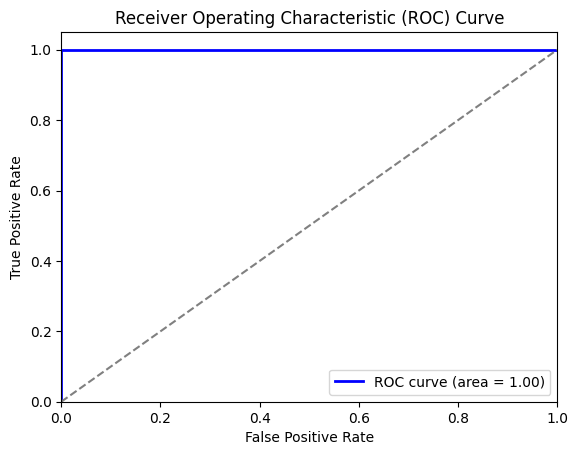

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()